<a href="https://colab.research.google.com/github/claredavies/ImageAnalysisAssignment/blob/main/ImageAnalysisAssignment1BeachPeopleCount.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [3]:
!pip install imutils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
!pip install --upgrade scikit-image

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.5 MB 27.5 MB/s 
  Attempting uninstall: scikit-image
    Found existing installation: scikit-image 0.18.3
    Uninstalling scikit-image-0.18.3:
      Successfully uninstalled scikit-image-0.18.3


In [5]:
from imutils.object_detection import non_max_suppression
import cv2
import numpy as np
import imutils 
import dlib
from google.colab import files
import io
import pandas as pd
import os
from os import listdir
import glob
import cv2
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow
from sklearn.metrics import mean_squared_error 
from skimage.metrics import structural_similarity as compare_ssim

In [6]:
pd.set_option('max_rows', 99999)
pd.set_option('max_colwidth', 400)
pd.describe_option('max_colwidth')

display.max_colwidth : int or None
    The maximum width in characters of a column in the repr of
    a pandas data structure. When the column overflows, a "..."
    placeholder is embedded in the output. A 'None' value means unlimited.
    [default: 50] [currently: 400]


# Read in files

In [7]:
!git clone https://github.com/claredavies/ImageAnalysisAssignment.git

Cloning into 'ImageAnalysisAssignment'...
remote: Enumerating objects: 106, done.
remote: Counting objects: 100% (106/106), done.
remote: Compressing objects: 100% (99/99), done.
remote: Total 106 (delta 34), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (106/106), 149.52 MiB | 9.87 MiB/s, done.
Resolving deltas: 100% (34/34), done.


In [8]:
%cd ImageAnalysisAssignment/Assignment1Data

/content/ImageAnalysisAssignment/Assignment1Data


Read in labels

In [9]:
labels = pd.read_csv('Labels/people-labels.csv')
labels.head(3)

,Label,X,Y,Filename,Width,Height
0,Person,317,563,1660194000.jpg,1920,1080
1,Person,248,564,1660194000.jpg,1920,1080
2,Person,266,576,1660194000.jpg,1920,1080


Read in images

In [10]:
# get the path/directory
folder_dir = "images"
for images in os.listdir(folder_dir):
 
    # check if the image ends with png
    if (images.endswith(".jpg")):
        print(images)

1660201200.jpg
1660208400.jpg
1660204800.jpg
1660219200.jpg
1660212000.jpg
1660194000.jpg
1660226400.jpg
1660197600.jpg
1660215600.jpg
1660222800.jpg


Algorithm design and implementation to i) identify every person and ii) count the number of
people in every photograph.

# Pre-processing functions

In [11]:
def histogram_equalisation(img: np.ndarray) -> np.array:
  ycrcb=cv2.cvtColor(img,cv2.COLOR_BGR2YCR_CB)
  channels=cv2.split(ycrcb)
  print(len(channels))
  cv2.equalizeHist(channels[0],channels[0])
  cv2.merge(channels,ycrcb)
  cv2.cvtColor(ycrcb,cv2.COLOR_YCR_CB2BGR,img)
  return img

In [12]:
def find_difference_images(currentImage, previousImage):
  result = np.zeros(currentImage.shape[0:2])

  if currentImage.ndim == 3:
    currentImage = cv2.cvtColor(currentImage, cv2.COLOR_BGR2GRAY)

  if previousImage.ndim == 3:
    previousImage = cv2.cvtColor(previousImage, cv2.COLOR_BGR2GRAY)

  h = currentImage.shape[0]
  w = previousImage.shape[1]

  # is 255 (white) or 0 (black)
  # loop over the image, pixel by pixel
  for y in range(0, h):
      for x in range(0, w):
          # threshold the pixel
          if(currentImage[y][x] == 0 and previousImage[y][x] == 255):
            result[y, x] = 255
  result = cv2.convertScaleAbs(result)
  return result

In [13]:
def apply_mask(image, mask):
  th = 1
  imask =  mask>th
  canvas = np.zeros_like(image, np.uint8)
  canvas[imask] = image[imask]
  return canvas

In [14]:
def remove_shadows(img):  
  # convert to gray
  gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

  # blur
  smooth = cv2.GaussianBlur(gray, (95,95), 0)

  # divide gray by morphology image
  division = cv2.divide(gray, smooth, scale=192)
  return division

In [15]:
def preprocess(frame):
  # convert to gray
  gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
  # blur
  smooth = cv2.GaussianBlur(gray, (95,95), 0)
  # divide gray by morphology image
  division = cv2.divide(gray, smooth, scale=192)
  # convert to black & white
  (thresh, im_bw) = cv2.threshold(division, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

  return im_bw

# Background Substraction

In [16]:
def motionDetection(image_path_folder):  
  list_image_name = []
  list_positions_head_found_x = []
  list_positions_head_found_y = []

  image_paths = glob.glob(image_path_folder)
  previous = cv2.imread("images/1660194000.jpg") 
  previous = preprocess(previous)

  for image_path in image_paths:
    image_name = image_path.split(os.path.sep)[-1]
    frame = cv2.imread(image_path) 

    frame_preprocessed = preprocess(frame)

    # print("previous and current")
    # cv2_imshow(previous)
    # cv2_imshow(frame_preprocessed)

    diff = find_difference_images(frame_preprocessed, previous)
    # print("difference")
    # cv2_imshow(diff)

    contours, hierarchy = cv2.findContours(diff, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # draw the contours, not strictly necessary
    # for i, cnt in enumerate(contours):
    #     cv2.drawContours(frame, contours, i, (0, 0, 255), 3)
    for contour in contours:
        # continue through the loop if contour area is less than 500...
        # ... helps in removing noise detection
        if cv2.contourArea(contour) < 500:
            continue
        # get the xmin, ymin, width, and height coordinates from the contours
        (x, y, w, h) = cv2.boundingRect(contour)
        center = (x+w//2, y+h//2)
        # draw the bounding boxes
        # cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)

        list_image_name.append(image_name)
        list_positions_head_found_x.append(center[0])
        list_positions_head_found_y.append(center[1])

    # cv2_imshow(frame)
    previous = frame_preprocessed

  df_image_head_pos= pd.DataFrame(
      {"Filename": list_image_name, "X": list_positions_head_found_x, "Y": list_positions_head_found_y}
  )
  df_image_head_pos.drop_duplicates()
  return df_image_head_pos

# Haar Cascade

In [21]:
def detectHaarcascadeImage(img, haarcascade):
  list_points_found_per_image = []
  if(len(img.shape) ==3):
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  else:
    img_gray = img
  img_gray = cv2.equalizeHist(img_gray)
  haarcascade_found = haarcascade.detectMultiScale(img_gray, scaleFactor=1.05,minNeighbors=5)
  for (x,y,w,h) in haarcascade_found:
    center = (x+w//2, y+h//2)
    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)
    list_points_found_per_image.append(center)
      # haarcascade_outer_foundROI = img_gray[y:y+h,x:x+w]
  # cv2_imshow(img)
  return list_points_found_per_image

In [19]:
def HaarcascadeImageFolder(image_path_folder):
  list_image_name = []
  list_positions_head_found_x = []
  list_positions_head_found_y = []
  image_paths = glob.glob(image_path_folder)

  full_body_cascade = cv2.CascadeClassifier(os.path.join(cv2.data.haarcascades + "haarcascade_fullbody.xml"))
  for image_path in image_paths:
    image_name = image_path.split(os.path.sep)[-1]
    image = cv2.imread(image_path)
    list_points_found_per_image = detectHaarcascadeImage(image, full_body_cascade)  

    for x in list_points_found_per_image:
      list_image_name.append(image_name)
      list_positions_head_found_x.append(x[0])
      list_positions_head_found_y.append(x[1])

  df_image_head_pos= pd.DataFrame(
      {"Filename": list_image_name, "X": list_positions_head_found_x, "Y": list_positions_head_found_y}
  )
  df_image_head_pos.drop_duplicates()
  return df_image_head_pos

# HOG - feature Detection - want to use non_max_suppression to get rid of overlapping

In [26]:
def HOGImage(image):
  scaleFactor = 2
  minNeighbors = 1

  list_points_found_per_image = []

  hog = cv2.HOGDescriptor()
  hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())

  # keep a minimum image size for accurate predictions
  if image.shape[1] < 400: # if image width < 400
    (height, width) = image.shape[:2]
    ratio = width / float(width) # find the width to height ratio
    image = cv2.resize(image, (400, width*ratio)) # resize the image according to the width to height ratio

  if(len(image.shape) == 3):
    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  else:
    img_gray = image

  rects, weights = hog.detectMultiScale(img_gray, winStride=(2, 2), padding=(10, 10), scale=0.5)
  for i, (x, y, w, h) in enumerate(rects):
    center = (x+w//2, y+h//2)
    if weights[i] < 0.13:
      continue
    elif weights[i] < 0.3 and weights[i] > 0.13:
      cv2.rectangle(image, (x, y), (x+w, y+h), (0, 0, 255), 2)
      list_points_found_per_image.append(center)
    if weights[i] < 0.7 and weights[i] > 0.3:
      cv2.rectangle(image, (x, y), (x+w, y+h), (50, 122, 255), 2)
      list_points_found_per_image.append(center)
    if weights[i] > 0.7:
      cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)
      list_points_found_per_image.append(center)

  # cv2_imshow(image)
  return list_points_found_per_image

In [27]:
def HOGImageFolder(image_path_folder):
  list_image_name = []
  list_positions_head_found_x = []
  list_positions_head_found_y = []
  image_paths = glob.glob(image_path_folder)
  for image_path in image_paths:
    image_name = image_path.split(os.path.sep)[-1]
    image = cv2.imread(image_path)
    list_points_found_per_image = HOGImage(image)  

    for x in list_points_found_per_image:
      list_image_name.append(image_name)
      list_positions_head_found_x.append(x[0])
      list_positions_head_found_y.append(x[1])

  df_image_head_pos= pd.DataFrame(
      {"Filename": list_image_name, "X": list_positions_head_found_x, "Y": list_positions_head_found_y}
  )
  df_image_head_pos.drop_duplicates()
  return df_image_head_pos

# Mean Squared Error Functions

In [32]:
def removeFalsePositives(labels, dfPeopleFound):
  labels['FoundX'] = 0
  labels['FoundY'] = 0

  threshold_cutoff = 5
  for indexOuter, rowOuter in labels.iterrows():
    for indexInner, rowInner in dfPeopleFound.iterrows():
      if rowOuter['Filename'] ==  rowInner['Filename']:
        if abs(rowOuter['X']- rowInner['X']) < threshold_cutoff:
          if abs(rowOuter['Y']- rowInner['Y']) < threshold_cutoff:
            # print("Found:  x:" + str(rowInner['X']) + "  y:" + str(rowInner['Y']))
            # print("Actual:  x:" + str(rowOuter['X']) + "  y:" + str(rowOuter['Y']))
            labels.at[indexOuter,'FoundX'] = rowInner['X']
            labels.at[indexOuter,'FoundY'] = rowInner['Y']
  
  return labels

In [49]:
def findMeanSquaredError(labels, dfPeopleFound):
  labels = removeFalsePositives(labels, dfPeopleFound)

  subset = labels[(labels["FoundX"] != 0) | (labels["FoundY"] != 0)]
  print("labels after false positives removed:  ")
  print(subset)

  if subset.empty:
    print('Not matches after matching to original labels')

  else:  
    mseY = mean_squared_error(subset.Y, subset.FoundY)
    mseX = mean_squared_error(subset.X, subset.FoundX)

    print("mseY:  " + str(mseY))
    print("mseX:  " + str(mseX))

# Execution

In [28]:
image_path = 'images/*.jpg'

HOG

In [47]:
dfHogFound = HOGImageFolder(image_path)
labelsHOGCopy = labels.copy()
findMeanSquaredError(labelsHOGCopy, dfHogFound)

labels after false positives removed:  
      Label    X    Y        Filename  Width  Height  FoundX  FoundY
184  Person  328  722  1660222800.jpg   1920    1080     327     723
mseY:  1.0
mseX:  1.0


Haar

In [48]:
dfHaarFound = HaarcascadeImageFolder(image_path)
# print(dfHaarFound)
labelsHaarCopy = labels.copy()
# print(labelsHaarCopy)
findMeanSquaredError(labelsHaarCopy, dfHaarFound)

labels after false positives removed:  
Empty DataFrame
Columns: [Label, X, Y, Filename, Width, Height, FoundX, FoundY]
Index: []
Not matches after matching to original labels


Motion Detection

In [50]:
dfMotionFound = motionDetection(image_path)
labelsMotionCopy = labels.copy()
findMeanSquaredError(labelsMotionCopy, dfMotionFound)

labels after false positives removed:  
Empty DataFrame
Columns: [Label, X, Y, Filename, Width, Height, FoundX, FoundY]
Index: []
Not matches after matching to original labels


# Blob detection

here


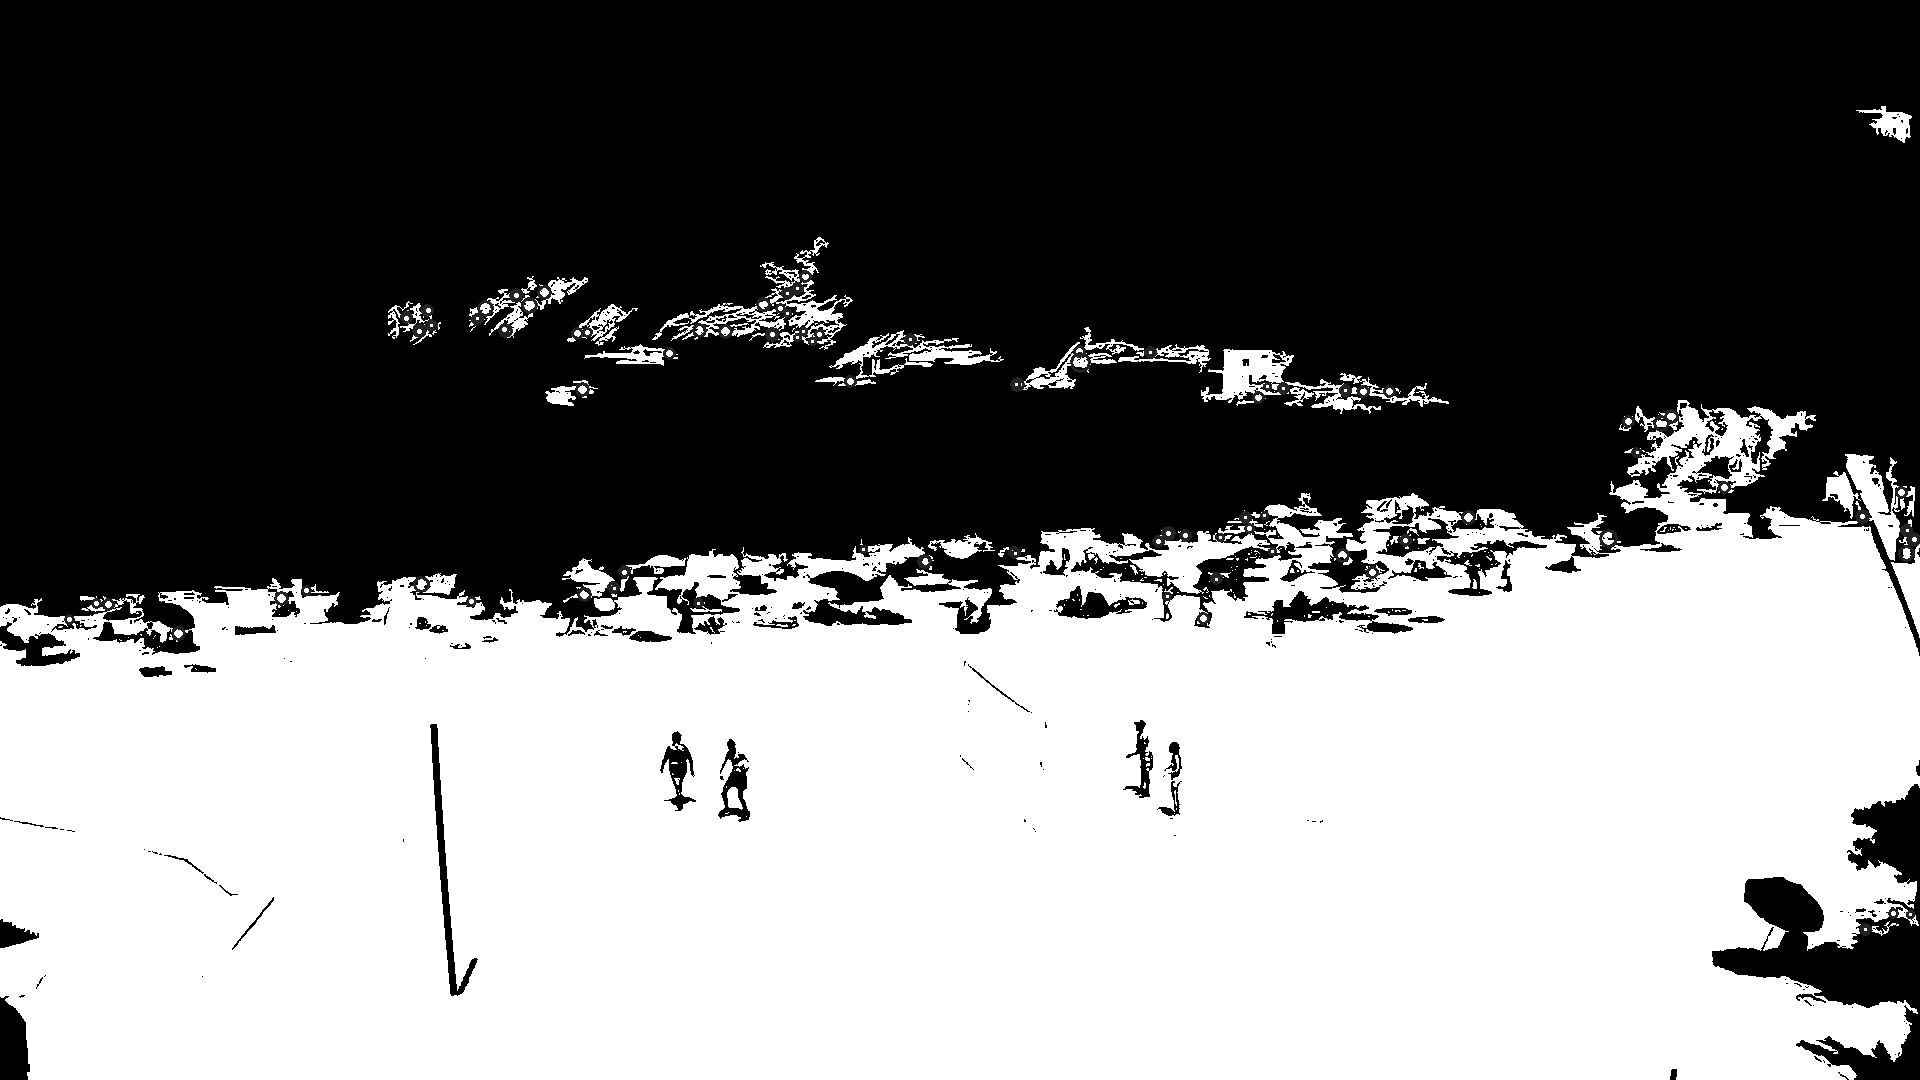

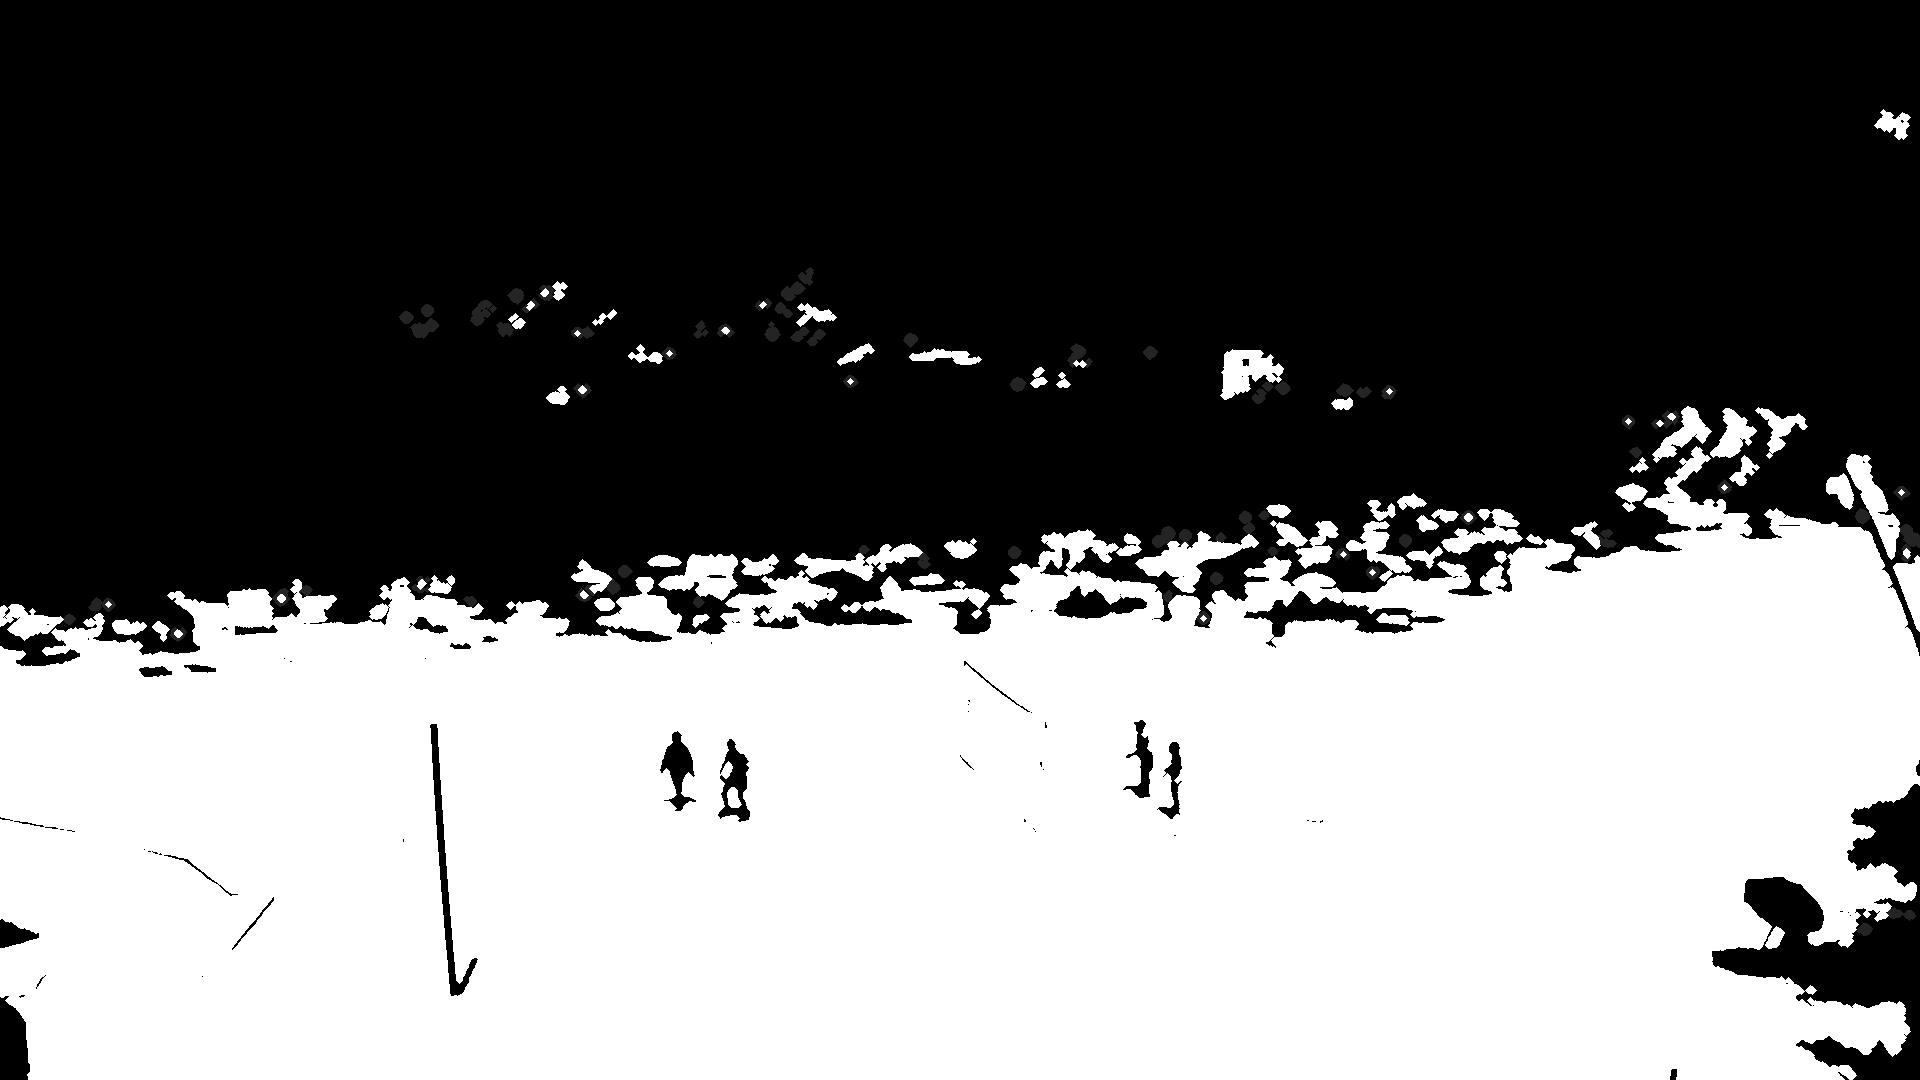

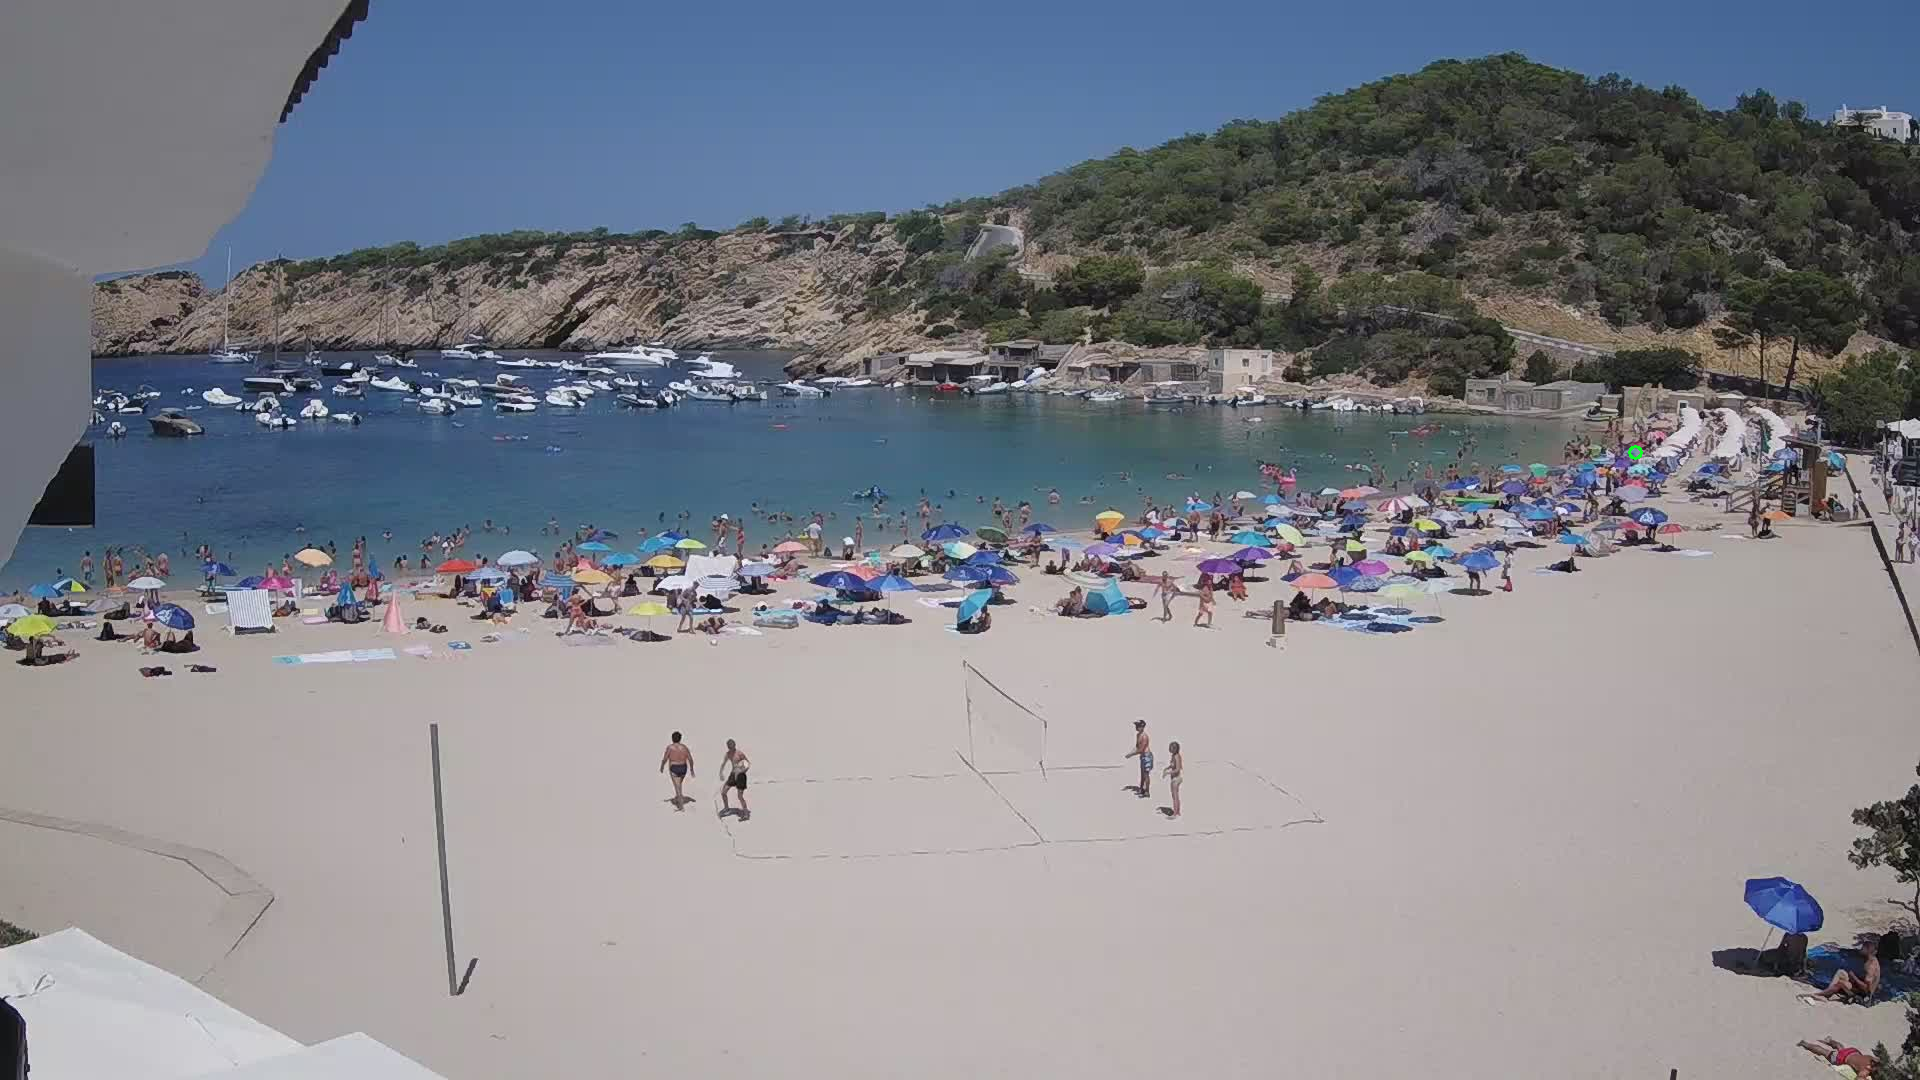

-1

In [ ]:
# Load image, grayscale, Otsu's threshold
image = cv2.imread('images/1660215600.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
thresh = image2_black_white

# Filter out large non-connecting objects
cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
for c in cnts:
    area = cv2.contourArea(c)
    if area < 500:
        cv2.drawContours(thresh,[c],0,0,-1)

# Morph open using elliptical shaped kernel
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=3)

# Find circles 
cnts = cv2.findContours(opening, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
for c in cnts:
    area = cv2.contourArea(c)
    if area > 10 and area < 90:
        ((x, y), r) = cv2.minEnclosingCircle(c)
        print("here")
        cv2.circle(image, (int(x), int(y)), int(r), (36, 255, 12), 2)

cv2_imshow(thresh)
cv2_imshow(opening)
cv2_imshow(image)
cv2.waitKey()

# Evaluation - Person-level

In [ ]:
print(labels.head())

    Label     X    Y        Filename  Width  Height  FoundX  FoundY
0  Person   317  563  1660194000.jpg   1920    1080       0       0
1  Person   248  564  1660194000.jpg   1920    1080       0       0
2  Person   266  576  1660194000.jpg   1920    1080       0       0
3  Person   290  566  1660194000.jpg   1920    1080       0       0
4  Person  1176  511  1660197600.jpg   1920    1080       0       0


Actual

In [ ]:
labelsPerFile = labels.groupby(['Filename'])['Filename'].count()
totalNumPeople = len(labels)  
print("total number of person labels: " + str(totalNumPeople))

total number of person labels: 245


In [ ]:
print(labelsPerFile)

Filename
1660194000.jpg     4
1660197600.jpg     4
1660201200.jpg    12
1660204800.jpg    15
1660208400.jpg    16
1660212000.jpg    35
1660215600.jpg    65
1660219200.jpg    31
1660222800.jpg    18
1660226400.jpg    45
Name: Filename, dtype: int64


Turn series into dataframe of grouped no heads per image

In [ ]:
list_image_name = []
list_actual_number_heads = []
for image_name, total_people_per_image in labelsPerFile.items():
  list_image_name.append(image_name)
  list_actual_number_heads.append(total_people_per_image)
df_persons_found_versus_actual = pd.DataFrame(
      {"Filename": list_image_name, "Actual": list_actual_number_heads}
  )

In [ ]:
df_persons_found_versus_actual["Found"] = 0

In [ ]:
print(df_persons_found_versus_actual.head())

         Filename  Actual  Found
0  1660194000.jpg       4      0
1  1660197600.jpg       4      0
2  1660201200.jpg      12      0
3  1660204800.jpg      15      0
4  1660208400.jpg      16      0


In [ ]:
headsFoundPerFile = df_image_head_pos.groupby(['Filename'])['Filename'].count()
print(headsFoundPerFile)

Filename
1660201200.jpg    1
1660204800.jpg    2
1660215600.jpg    1
Name: Filename, dtype: int64


iterate through found and update actual table

In [ ]:
for image_name, total_people_per_image in headsFoundPerFile.items():
  df_persons_found_versus_actual.loc[df_persons_found_versus_actual["Filename"] == image_name, "Found"] = total_people_per_image

In [ ]:
print(df_persons_found_versus_actual)

         Filename  Actual  Found
0  1660194000.jpg       4      0
1  1660197600.jpg       4      0
2  1660201200.jpg      12      1
3  1660204800.jpg      15      2
4  1660208400.jpg      16      0
5  1660212000.jpg      35      0
6  1660215600.jpg      65      1
7  1660219200.jpg      31      0
8  1660222800.jpg      18      0
9  1660226400.jpg      45      0


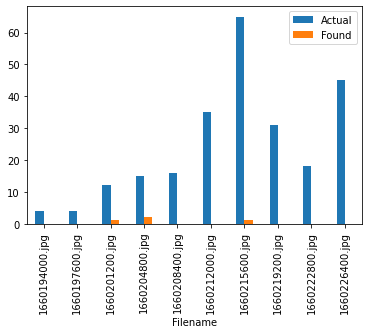

In [ ]:
df_persons_found_versus_actual.plot(x='Filename', y=['Actual','Found'], kind='bar') 
plt.show()

# Performance - Timings